## Spotify Skip RL Model

Elise Rust 

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import warnings
from itertools import tee

# Suppress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

warnings.filterwarnings("ignore")

## Data Pre-Processing
1. Join session level data with track context/features
2. Identify all unique transitions from song a to song b --> store in dictionary for future sampling during training
3. Convert rewards to binary 0 = skipped, 1 = not skipped
4. Encode categorical track and session features
5. Create Features dataframe which containes cleaned/OHE vector of track features
6. Generate session context encoding
    - How each session has responded to tracks of given features
    - Normalize features between 0 - 1
    - Multiply feature by 1 if user didn't skip, -1 if user did skip
    - I.e for a given session their context would look like
    
|duration|us_popularity|acousticness|beat_strength|bounciness|danceability|dyn_range|energy|flatness|etc.
|------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|   109.5|      99.2|      0.5|      0.7|      0.3|      0.2|      0.2|      7.5|      0.8|      etc.|

Normalize the session level response to song features on a 0-1 scale


In [2]:
# Load in Data
df_sessions_sampled = pd.read_csv('data/training_set/log_sampled.csv')
df_tracks_sampled = pd.read_csv('data/track_features/tf_sampled.csv')
print("Number of sessions in DF: " + str(len(df_sessions_sampled['session_id'].unique())))
print("Number of tracks in DF: " + str(len(df_tracks_sampled['track_id'].unique())))
# Sanity check num tracks in tracks df equals num tracks in sessions df
assert len(df_sessions_sampled['track_id_clean'].unique()) == len(df_tracks_sampled['track_id'].unique())

Number of sessions in DF: 178342
Number of tracks in DF: 319008


In [3]:
## Check for nulls, etc.
print("Missing values in sessions data: ", df_sessions_sampled.isna().sum())
print("Missing values in track data: ", df_sessions_sampled.isna().sum())

Missing values in sessions data:  session_id                         0
session_position                   0
session_length                     0
track_id_clean                     0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
dtype: int64
Missing values in track data:  session_id                         0
session_position                   0
session_length                     0
track_id_clean                    

In [4]:
## Examine columns and datatypes in each dataframe
print(df_sessions_sampled.dtypes)
print("-----------------------")
print(df_tracks_sampled.dtypes)

session_id                         object
session_position                    int64
session_length                      int64
track_id_clean                     object
skip_1                               bool
skip_2                               bool
skip_3                               bool
not_skipped                          bool
context_switch                      int64
no_pause_before_play                int64
short_pause_before_play             int64
long_pause_before_play              int64
hist_user_behavior_n_seekfwd        int64
hist_user_behavior_n_seekback       int64
hist_user_behavior_is_shuffle        bool
hour_of_day                         int64
date                               object
premium                              bool
context_type                       object
hist_user_behavior_reason_start    object
hist_user_behavior_reason_end      object
dtype: object
-----------------------
track_id                   object
duration                  float64
release_year

In [10]:
## Join dataframes together on 'track_id'
spotify = df_sessions_sampled.merge(df_tracks_sampled, left_on="track_id_clean", right_on="track_id")
print(spotify.isna().sum())
spotify.head()

session_id                         0
session_position                   0
session_length                     0
track_id_clean                     0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
track_id                           0
duration                           0
release_year                       0
us_popularity_estimate             0
acousticness                       0
beat_strength                      0
b

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.15,-0.82,0.39,0.23,0.03,-0.33,0.02,-0.35,0.21


In [11]:
## Drop unnecessary columns
spotify = spotify.drop(columns=['hist_user_behavior_reason_start', 'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'])

#### Encode rewards
- The agent learns via the 'skip' variables (this is how we get feedback on whether the user likes or doesn't like a given song)
- Convert 'skip_1', 'skip_2', 'skip_3', 'not_skipped' into binary 'skip' variable (1/0; -1 if user skips)

Reward is thus:
+1 if song is not skipped
-1 if song is skipped

In [12]:
# response = -1, track was skipped
# response = 1, track was not skipped
spotify['response'] = np.where(
    spotify['not_skipped']==True,
    1, -1)
spotify = spotify.drop(columns=['skip_1', 'skip_2', 'skip_3', 'not_skipped'])
spotify.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,response
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,1
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,-1
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,1
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,1
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.68,-6.58,0.55,major,0.32,0.07,134.02,4,0.15,-1


In [13]:
spotify['response'].value_counts()

-1    1985901
 1    1004708
Name: response, dtype: int64

## Encode relevant user context data - behavior
To booleans:
- shuffle (0/1)
- premium (0/1)

To numeric:
- date --> year, month

To OHE vectors:
- context (catalog, charts, editorial playlist, personalized playlist, radio, user collection)
- track end reason (appload, backbtn, clickrow, endplay, fwdbtn, logout, remote, trackdone)

In [14]:
# Convert binary columns to booleans
data_bool_cols = spotify.columns[spotify.dtypes=='bool']
for col in data_bool_cols:
    spotify[col]=spotify[col].astype(int)
spotify['mode'] = spotify['mode'].astype(bool).astype(int)

In [15]:
from datetime import datetime

spotify['date'] = pd.to_datetime(spotify.date, format='%Y-%m-%d')
spotify['year']=spotify['date'].dt.year
spotify['month']=spotify['date'].dt.month
spotify = spotify.drop(columns='date')
spotify.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,mechanism,mode,organism,speechiness,tempo,time_signature,valence,response,year,month
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.55,1,0.32,0.07,134.02,4,0.15,1,2018,7
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.55,1,0.32,0.07,134.02,4,0.15,-1,2018,7
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.55,1,0.32,0.07,134.02,4,0.15,1,2018,7
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.55,1,0.32,0.07,134.02,4,0.15,1,2018,7
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.55,1,0.32,0.07,134.02,4,0.15,-1,2018,7


In [16]:
# OHE Categorical Columns
categorical_columns =['context_type', 'hist_user_behavior_reason_end']
enc = OneHotEncoder()
array_hot_encoded = enc.fit_transform(spotify[categorical_columns]).toarray()
feature_labels = enc.categories_
feature_labels = np.concatenate(feature_labels, axis=0)
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns=feature_labels, index=spotify.index) # Convert OHE array to df
spotify = spotify.drop(columns=categorical_columns)
spotify_enc = pd.concat([spotify, data_hot_encoded], axis=1)
spotify_enc.head()

,session_id,session_position,session_length,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,appload,backbtn,clickrow,endplay,fwdbtn,logout,popup,remote,trackdone,uriopen
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,1,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,1,1,0,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


### Session Context Encoding - track preferences

In [17]:
feature_columns = ['duration', 'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mechanism', 'organism', 'speechiness', 'tempo', 'time_signature', 'valence']

In [18]:
# Normalize all features to be between 0 and 1
for i in feature_columns:
    spotify_enc[i] = (spotify_enc[i]-np.min(spotify_enc[i]))/(np.max(spotify_enc[i])-np.min(spotify_enc[i]))

In [19]:
spotify_enc[feature_columns].describe()

,duration,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence
count,"2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00","2,990,609.00"
mean,0.11,0.97,0.22,0.55,0.60,0.67,0.24,0.63,0.89,0.03,0.47,0.19,0.83,0.59,0.36,0.15,0.50,0.79,0.46
std,0.03,0.09,0.25,0.16,0.18,0.16,0.07,0.18,0.03,0.14,0.33,0.15,0.05,0.21,0.19,0.14,0.12,0.07,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.09,0.99,0.03,0.44,0.46,0.56,0.19,0.51,0.88,0.00,0.09,0.10,0.81,0.45,0.21,0.05,0.40,0.80,0.28
50%,0.10,1.00,0.12,0.55,0.61,0.69,0.23,0.63,0.90,0.00,0.45,0.13,0.84,0.64,0.32,0.09,0.51,0.80,0.44
75%,0.12,1.00,0.34,0.67,0.74,0.79,0.28,0.76,0.92,0.00,0.82,0.24,0.86,0.76,0.49,0.21,0.59,0.80,0.63
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [20]:
def encode_track_preferences(session_responses, feature_columns):
    '''
    Input:
    session_responses = dataframe of session (track features, behavior, etc.)
    song_context = list of variables related to track features
    '''

    # Get reviews of songs (1 vs. 0 skip outcome) * track features
    ratings = session_responses[feature_columns].mul(session_responses['response'], axis=0)
    
    # Average across session --> one vector per session
    session_pref = ratings.mean(axis=0)
    #print(session_pref)

    return session_pref


In [21]:
session_pref = spotify_enc.groupby('session_id').apply(lambda x: encode_track_preferences(x, feature_columns))

In [22]:
session_pref.index.name = 'session_id'
session_pref.reset_index(inplace=True)

In [23]:
session_pref.head()

,session_id,duration,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,-0.04,-0.38,-0.10,-0.24,-0.29,-0.26,-0.12,-0.21,-0.37,0.00,-0.07,-0.05,-0.33,-0.16,-0.19,-0.11,-0.19,-0.34,-0.13
1,0_0000a72b-09ac-412f-b452-9b9e79bded8f,-0.05,-0.31,-0.07,-0.16,-0.17,-0.17,-0.07,-0.37,-0.32,-0.09,-0.21,-0.21,-0.34,-0.14,-0.22,-0.05,-0.22,-0.32,-0.20
2,0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a,-0.10,-0.80,-0.09,-0.49,-0.53,-0.58,-0.21,-0.50,-0.72,-0.03,-0.39,-0.14,-0.68,-0.50,-0.24,-0.19,-0.41,-0.66,-0.37
3,0_00016a3d-9076-4f67-918f-f29e3ce160dc,-0.05,-0.59,-0.03,-0.29,-0.27,-0.38,-0.11,-0.51,-0.52,0.01,-0.35,-0.09,-0.53,-0.49,-0.09,-0.03,-0.26,-0.48,-0.45
4,0_00018b58-deb8-4f98-ac5e-d7e01b346130,-0.00,0.10,-0.16,0.03,0.04,0.08,0.02,0.18,0.07,-0.00,-0.11,0.02,0.10,0.20,-0.13,-0.01,0.10,0.07,0.15


In [24]:
tracks = spotify_enc[['track_id_clean','duration', 'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key', 'liveness',
        'loudness', 'mechanism', 'organism', 'speechiness', 'tempo', 'time_signature', 'valence']]

In [25]:
tracks = tracks.drop_duplicates()

In [26]:
tracks = tracks.reset_index()

In [27]:
tracks = tracks.iloc[:,1:]

In [28]:
tracks.head()

,track_id_clean,duration,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence
0,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.08,1.00,0.02,0.44,0.49,0.66,0.20,0.55,0.92,0.00,0.09,0.68,0.84,0.55,0.33,0.07,0.55,0.80,0.15
1,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0.12,0.99,0.06,0.66,0.76,0.88,0.30,0.73,0.91,0.00,0.64,0.10,0.86,0.82,0.14,0.06,0.53,0.80,0.34
2,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0.11,1.00,0.36,0.54,0.56,0.68,0.21,0.56,0.91,0.00,0.91,0.14,0.85,0.77,0.31,0.05,0.59,0.80,0.37
3,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0.08,1.00,0.77,0.65,0.75,0.87,0.30,0.53,0.88,0.00,0.09,0.10,0.82,0.63,0.62,0.24,0.46,0.80,0.65
4,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0.10,1.00,0.01,0.74,0.82,0.86,0.32,0.65,0.89,0.00,0.73,0.12,0.87,0.76,0.18,0.25,0.60,0.80,0.65


In [29]:
def cosine_sim(A, B):
    A = np.array(A)
    B = np.array(B)
    return A.dot(B)/(np.sqrt(np.sum(A**2))*np.sqrt(np.sum(B**2)))

In [30]:
def show_track(track_context, user_context):

    raw_rating = cosine_sim(track_context, user_context)
    rating = np.clip(round(raw_rating), 0, 1)
    # rating = np.clip(round(2+10*raw_rating) / 2, 0.5, 5.0)

    return rating

In [31]:
def ground_truth(session_context, track_features):
    track_features = np.array(track_features)
    session_context = np.array(session_context)
    try: return np.array([cosine_sim(i,session_context) for i in track_features])
    except: return cosine_sim(track_features, session_context)

In [32]:
def calculate_regret(selected_rated, inventory_ratings):
    return max(inventory_ratings) - selected_rated

In [33]:
session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]

In [34]:
user_context_evaluate = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]

In [35]:
# sanity check
# response = -1, track was only played very briefly and skipped 
# response = 1, most of the track was played and skipped
for i in range(20):
    print('cosine similarity:',np.round(cosine_sim(user_context_evaluate, np.array(spotify_enc[spotify_enc.session_id ==session_id_sample][feature_columns])[i]),3),
          '---------',
         'response: ',spotify_enc[spotify_enc.session_id ==session_id_sample].response.iloc[i])
    

cosine similarity: -0.971 --------- response:  1
cosine similarity: -0.974 --------- response:  -1
cosine similarity: -0.969 --------- response:  -1
cosine similarity: -0.964 --------- response:  -1
cosine similarity: -0.984 --------- response:  -1
cosine similarity: -0.996 --------- response:  -1
cosine similarity: -0.985 --------- response:  -1
cosine similarity: -0.981 --------- response:  -1
cosine similarity: -0.993 --------- response:  -1
cosine similarity: -0.991 --------- response:  -1
cosine similarity: -0.991 --------- response:  -1
cosine similarity: -0.985 --------- response:  -1
cosine similarity: -0.985 --------- response:  -1
cosine similarity: -0.985 --------- response:  -1
cosine similarity: -0.966 --------- response:  -1
cosine similarity: -0.968 --------- response:  -1
cosine similarity: -0.99 --------- response:  -1
cosine similarity: -0.993 --------- response:  -1
cosine similarity: -0.981 --------- response:  -1
cosine similarity: -0.99 --------- response:  -1


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# OTHER USEFUL PYTHON MODULES AND PACKAGES
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
import imageio

# BASE PYTHON IMPORTS
import random
from collections import deque, namedtuple
from itertools import count
from time import time
from pathlib import Path


# SET UP MATPLOTLIB
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [37]:
class DNN(nn.Module):

    # DEFINE THE SPECIAL INIT METHOD
    def __init__(self, features, hidden, output):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output)
        )
    # DEFINE THE FORWARD METHOD
    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [38]:
x_dimension = 38

In [39]:
"""Baseline: DNN with Random selection"""
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN(x_dimension, 400, 1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), amsgrad=True, lr = learning_rate)

import math
impressions = 10000
n_movie_inventory = 30
batch_size = 64
eps = [0.05] 
regret_vec_dnn_random = {}
train_loss = []
for e in eps:
    print('e = ',e, '\n')
    movie_model = model
    X = []
    y = []
    total_regret = 0
    regret_vec_dnn_random[e] = []
    
    for i in range(impressions):
        # SAMPLE ALL MOVIES FOR THE MOVIE INVENTORY
        movie_inventory = tracks.sample(n = n_movie_inventory)
        movie_context = {i[0]: i[1:] for i in np.array(movie_inventory)}
        
        # SAMPLE A SINGLE USER FROM THE FULL LIST AND SAVE THE USER'S CONTEXT
        session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]
        user_context = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]
        # user_context = np.array(spotify_enc[spotify_enc.session_id == session_id_sample].sample(5)[feature_columns]).flatten()

        # 114 features
        
        # IF THE RANDOM FOREST HAS NOT BEEN TRAINED WE MAKE A RANDOM SELECTION
        # if i < batch_size:
        selected_movie_id = np.random.choice(list(movie_context.keys()))
        selected_x = np.concatenate((user_context ,movie_context[selected_movie_id]), axis = None).reshape(x_dimension,)
        
        # GET THE USER'S RATING (GROUND TRUTH) FOR THE SELECTED MOVIE
        truth_selected_rate = cosine_sim(user_context, movie_context[selected_movie_id])
        truth_rates = ground_truth(user_context, np.array(movie_inventory)[:,1:])
        # print(truth_rates)

        # CALCULATE THE REGRET
        regret = calculate_regret(truth_selected_rate, truth_rates)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if math.isnan(truth_selected_rate):
            continue
        else:
            X.append(selected_x)
            y.append(truth_selected_rate)

        total_regret += regret
        regret_vec_dnn_random[e].append(total_regret)
        
        idx = batch_size

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1))
            
            train_x = torch.tensor(X[idx-batch_size:idx], dtype = torch.float32)
            train_y = torch.tensor(y[idx-batch_size:idx], dtype = torch.float32)
            # MAKE MODEL PREDICTION
            pred = model.forward(train_x)
            # CALCULATE THE LOSS
            loss = loss_fn(pred, train_y)
            # ZERO OUT GRADIENT (RESET TO 0)
            optimizer.zero_grad()
            # CALCULATE THE GRADIENTS
            loss.backward()
            # UPDATE THE MODEL PARAMETERS
            optimizer.step()
            # INCREMENT THE BATCH INDEXER AND COUNTER
            
            idx+=batch_size

            train_loss.append(loss)

e =  0.05 

Updating the model after 64 impressions
Updating the model after 128 impressions
Updating the model after 192 impressions
Updating the model after 256 impressions
Updating the model after 320 impressions
Updating the model after 384 impressions
Updating the model after 448 impressions
Updating the model after 512 impressions
Updating the model after 576 impressions
Updating the model after 640 impressions
Updating the model after 704 impressions
Updating the model after 768 impressions
Updating the model after 832 impressions
Updating the model after 896 impressions
Updating the model after 960 impressions
Updating the model after 1024 impressions
Updating the model after 1088 impressions
Updating the model after 1152 impressions
Updating the model after 1216 impressions
Updating the model after 1280 impressions
Updating the model after 1344 impressions
Updating the model after 1408 impressions
Updating the model after 1472 impressions
Updating the model after 1536 impressi

In [40]:
'''DNN'''
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DNN(x_dimension, 400, 1).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), amsgrad=True, lr = learning_rate)

def eps_greedy(model, session_context, track_inventory, eps):
    selected_track = None
    selected_x = None
    max_action_val = -100
    
    # IF A RANDOM NUMBER BETWEEN 0 AND 1 IS LESS THAN OUR EPS HYPERPARAMETER WE CHOOSE A RANDOM AD
    if np.random.uniform() < eps:
        selected_track = np.random.choice(list(track_inventory.keys()))
        selected_x = np.concatenate((session_context ,track_inventory[selected_track]), axis = None).reshape(x_dimension,)

    # OTHERWISE WE GET THE AD(S) WITH THE HIGHEST PREDICTED CTR(S)
    else:
        
        for track in track_inventory.items():

            x = np.concatenate((session_context, track[1]), axis = None).reshape(1,-1) 
            x=np.vstack(x).astype(np.float)
            x = torch.from_numpy(x)
            action_val_pred = model.forward(x.float())

            if action_val_pred >= max_action_val:
                max_action_val = action_val_pred
                selected_track = track[0]

                selected_x = x

    return selected_track, selected_x.reshape(x_dimension,)

import math
impressions = 10000
n_movie_inventory = 30
batch_size = 64
eps = [0.05] 
regret_vec_dnn = {}
train_loss = []
for e in eps:
    print('e = ',e, '\n')
    movie_model = model
    X = []
    y = []
    total_regret = 0
    regret_vec_dnn[e] = []
    
    for i in range(impressions):
        # SAMPLE ALL MOVIES FOR THE MOVIE INVENTORY
        movie_inventory = tracks.sample(n = n_movie_inventory)
        movie_context = {i[0]: i[1:] for i in np.array(movie_inventory)}
        
        # SAMPLE A SINGLE USER FROM THE FULL LIST AND SAVE THE USER'S CONTEXT
        session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]
        user_context = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]
        # user_context = np.array(spotify_enc[spotify_enc.session_id == session_id_sample].sample(5)[feature_columns]).flatten()

        # 114 features
        
        # IF THE RANDOM FOREST HAS NOT BEEN TRAINED WE MAKE A RANDOM SELECTION
        if i < batch_size:
            selected_movie_id = np.random.choice(list(movie_context.keys()))
            selected_x = np.concatenate((user_context ,movie_context[selected_movie_id]), axis = None).reshape(x_dimension,)
        # ELSE WE SELECT THE MOVIE WITH THE HIGHEST PREDICTED REVIEW
        else:
            selected_movie_id, selected_x = eps_greedy(movie_model, user_context, movie_context, e)
            
        # user_context_evaluate = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]
        
        # GET THE USER'S RATING (GROUND TRUTH) FOR THE SELECTED MOVIE
        truth_selected_rate = cosine_sim(user_context, movie_context[selected_movie_id])
        truth_rates = ground_truth(user_context, np.array(movie_inventory)[:,1:])
        # print(truth_rates)

        # CALCULATE THE REGRET
        regret = calculate_regret(truth_selected_rate, truth_rates)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if math.isnan(truth_selected_rate):
            continue
        else:
            X.append(selected_x)
            y.append(truth_selected_rate)

        total_regret += regret
        regret_vec_dnn[e].append(total_regret)
        
        idx = batch_size

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1))
            
            train_x = torch.tensor(X[idx-batch_size:idx], dtype = torch.float32)
            train_y = torch.tensor(y[idx-batch_size:idx], dtype = torch.float32)
            # MAKE MODEL PREDICTION
            pred = model.forward(train_x)
            # CALCULATE THE LOSS
            loss = loss_fn(pred, train_y)
            # ZERO OUT GRADIENT (RESET TO 0)
            optimizer.zero_grad()
            # CALCULATE THE GRADIENTS
            loss.backward()
            # UPDATE THE MODEL PARAMETERS
            optimizer.step()
            # INCREMENT THE BATCH INDEXER AND COUNTER
            
            idx+=batch_size

            train_loss.append(loss)


e =  0.05 

Updating the model after 64 impressions
Updating the model after 128 impressions
Updating the model after 192 impressions
Updating the model after 256 impressions
Updating the model after 320 impressions
Updating the model after 384 impressions
Updating the model after 448 impressions
Updating the model after 512 impressions
Updating the model after 576 impressions
Updating the model after 640 impressions
Updating the model after 704 impressions
Updating the model after 768 impressions
Updating the model after 832 impressions
Updating the model after 896 impressions
Updating the model after 960 impressions
Updating the model after 1024 impressions
Updating the model after 1088 impressions
Updating the model after 1152 impressions
Updating the model after 1216 impressions
Updating the model after 1280 impressions
Updating the model after 1344 impressions
Updating the model after 1408 impressions
Updating the model after 1472 impressions
Updating the model after 1536 impressi

In [41]:
'''LR'''
from sklearn.linear_model import LinearRegression
import math
def eps_greedy(model, session_context, track_inventory, eps):
    selected_track = None
    selected_x = None
    max_action_val = -100
    
    # IF A RANDOM NUMBER BETWEEN 0 AND 1 IS LESS THAN OUR EPS HYPERPARAMETER WE CHOOSE A RANDOM AD
    if np.random.uniform() < eps:
        selected_track = np.random.choice(list(track_inventory.keys()))
        selected_x = np.concatenate((session_context ,track_inventory[selected_track]), axis = None).reshape(x_dimension,)    
    # OTHERWISE WE GET THE AD(S) WITH THE HIGHEST PREDICTED CTR(S)
    else:
        for track in track_inventory.items():
            x = np.concatenate((session_context, track[1]), axis = None).reshape(1,-1)            
            action_val_pred = model.predict(x)
            if action_val_pred >= max_action_val:
                max_action_val = action_val_pred
                selected_track = track[0]
                selected_x = x

    return selected_track, selected_x.reshape(x_dimension,)

impressions = 10000
n_movie_inventory = 5
batch_size = 100
eps = [0.05] 
regret_vec_lr = {}
for e in eps:
    print('e = ',e, '\n')
    lr_model = LinearRegression()
    X = []
    y = []
    total_regret = 0
    regret_vec_lr[e] = []
    
    for i in range(impressions):
        # SAMPLE ALL MOVIES FOR THE MOVIE INVENTORY
        movie_inventory = tracks.sample(n = n_movie_inventory)
        movie_context = {i[0]: i[1:] for i in np.array(movie_inventory)}
        
        # SAMPLE A SINGLE USER FROM THE FULL LIST AND SAVE THE USER'S CONTEXT
        session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]
        user_context = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]
        
        # IF THE RANDOM FOREST HAS NOT BEEN TRAINED WE MAKE A RANDOM SELECTION
        if i < batch_size:
            selected_movie_id = np.random.choice(list(movie_context.keys()))
            selected_x = np.concatenate((user_context ,movie_context[selected_movie_id]), axis = None).reshape(x_dimension,)
        # ELSE WE SELECT THE MOVIE WITH THE HIGHEST PREDICTED REVIEW
        else:
            selected_movie_id, selected_x = eps_greedy(lr_model, user_context, movie_context, e)
            
        
        # GET THE USER'S RATING (GROUND TRUTH) FOR THE SELECTED MOVIE
        truth_selected_rate = cosine_sim(user_context, movie_context[selected_movie_id])
        truth_rates = ground_truth(user_context, np.array(movie_inventory)[:,1:])

        regret = calculate_regret(truth_selected_rate, truth_rates)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if ~np.isfinite(selected_x.astype(float)).any() or math.isnan(truth_selected_rate):
            continue
        else:
            X.append(selected_x)
            y.append(truth_selected_rate)

        total_regret += regret
        regret_vec_lr[e].append(total_regret)

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1))
            lr_model.fit(X,y)

e =  0.05 

Updating the model after 100 impressions
Updating the model after 200 impressions
Updating the model after 300 impressions
Updating the model after 400 impressions
Updating the model after 500 impressions
Updating the model after 600 impressions
Updating the model after 700 impressions
Updating the model after 800 impressions
Updating the model after 900 impressions
Updating the model after 1000 impressions
Updating the model after 1100 impressions
Updating the model after 1200 impressions
Updating the model after 1300 impressions
Updating the model after 1400 impressions
Updating the model after 1500 impressions
Updating the model after 1600 impressions
Updating the model after 1700 impressions
Updating the model after 1800 impressions
Updating the model after 1900 impressions
Updating the model after 2000 impressions
Updating the model after 2100 impressions
Updating the model after 2200 impressions
Updating the model after 2300 impressions
Updating the model after 2400 i

In [42]:
'''GB'''
def eps_greedy(model, session_context, track_inventory, eps):
    selected_track = None
    selected_x = None
    max_action_val = -100
    
    # IF A RANDOM NUMBER BETWEEN 0 AND 1 IS LESS THAN OUR EPS HYPERPARAMETER WE CHOOSE A RANDOM AD
    if np.random.uniform() < eps:
        selected_track = np.random.choice(list(track_inventory.keys()))
        selected_x = np.concatenate((session_context ,track_inventory[selected_track]), axis = None).reshape(x_dimension,)    
    # OTHERWISE WE GET THE AD(S) WITH THE HIGHEST PREDICTED CTR(S)
    else:
        for track in track_inventory.items():
            x = np.concatenate((session_context, track[1]), axis = None).reshape(1,-1)            
            action_val_pred = model.predict(x)
            if action_val_pred >= max_action_val:
                max_action_val = action_val_pred
                selected_track = track[0]
                selected_x = x

    return selected_track, selected_x.reshape(x_dimension,)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import math
impressions = 10000
n_movie_inventory = 5
batch_size = 100
eps = [0.05] 
regret_vec_gb = {}
for e in eps:
    print('e = ',e, '\n')
    gbr_model = GradientBoostingRegressor(random_state=0)
    X = []
    y = []
    total_regret = 0
    regret_vec_gb[e] = []
    
    for i in range(impressions):
        # SAMPLE ALL MOVIES FOR THE MOVIE INVENTORY
        movie_inventory = tracks.sample(n = n_movie_inventory)
        movie_context = {i[0]: i[1:] for i in np.array(movie_inventory)}
        
        # SAMPLE A SINGLE USER FROM THE FULL LIST AND SAVE THE USER'S CONTEXT
        session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]
        user_context = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]
        
        # IF THE RANDOM FOREST HAS NOT BEEN TRAINED WE MAKE A RANDOM SELECTION
        if i < batch_size:
            selected_movie_id = np.random.choice(list(movie_context.keys()))
            selected_x = np.concatenate((user_context ,movie_context[selected_movie_id]), axis = None).reshape(x_dimension,)
        # ELSE WE SELECT THE MOVIE WITH THE HIGHEST PREDICTED REVIEW
        else:
            selected_movie_id, selected_x = eps_greedy(gbr_model, user_context, movie_context, e)
        
        
        # GET THE USER'S RATING (GROUND TRUTH) FOR THE SELECTED MOVIE
        truth_selected_rate = cosine_sim(user_context, movie_context[selected_movie_id])
        truth_rates = ground_truth(user_context, np.array(movie_inventory)[:,1:])

        regret = calculate_regret(truth_selected_rate, truth_rates)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if ~np.isfinite(selected_x.astype(float)).any() or math.isnan(truth_selected_rate):
            continue
        else:
            X.append(selected_x)
            y.append(truth_selected_rate)

        total_regret += regret
        regret_vec_gb[e].append(total_regret)

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1))
            gbr_model.fit(X,y)

e =  0.05 

Updating the model after 100 impressions
Updating the model after 200 impressions
Updating the model after 300 impressions
Updating the model after 400 impressions
Updating the model after 500 impressions
Updating the model after 600 impressions
Updating the model after 700 impressions
Updating the model after 800 impressions
Updating the model after 900 impressions
Updating the model after 1000 impressions
Updating the model after 1100 impressions
Updating the model after 1200 impressions
Updating the model after 1300 impressions
Updating the model after 1400 impressions
Updating the model after 1500 impressions
Updating the model after 1600 impressions
Updating the model after 1700 impressions
Updating the model after 1800 impressions
Updating the model after 1900 impressions
Updating the model after 2000 impressions
Updating the model after 2100 impressions
Updating the model after 2200 impressions
Updating the model after 2300 impressions
Updating the model after 2400 i

In [44]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

def mlp_model(X, Y):

    estimator=MLPRegressor()


    param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
            'activation': ['relu','tanh','logistic'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            'solver': ['adam']}

    gsc = GridSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)


    best_params = grid_result.best_params_

    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                            activation =best_params["activation"],
                            solver=best_params["solver"],
                            max_iter= 5000, n_iter_no_change = 200
                )

    scoring = {
            'abs_error': 'neg_mean_absolute_error',
            'squared_error': 'neg_mean_squared_error',
            'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)
    return scores

In [45]:
'''MLP Regressor'''
from sklearn.neural_network import MLPRegressor
import math
impressions = 10000
n_movie_inventory = 5
batch_size = 100
eps = [0.05] 
regret_vec_MLP = {}
for e in eps:
    print('e = ',e, '\n')
    model = MLPRegressor()
    X = []
    y = []
    total_regret = 0
    regret_vec_MLP[e] = []
    
    for i in range(impressions):
        # SAMPLE ALL MOVIES FOR THE MOVIE INVENTORY
        movie_inventory = tracks.sample(n = n_movie_inventory)
        movie_context = {i[0]: i[1:] for i in np.array(movie_inventory)}
        
        # SAMPLE A SINGLE USER FROM THE FULL LIST AND SAVE THE USER'S CONTEXT
        session_id_sample = np.array(spotify_enc.sample(n = 1))[0][0]
        user_context = np.array(session_pref[session_pref.session_id == session_id_sample])[0,1:]
        
        # IF THE RANDOM FOREST HAS NOT BEEN TRAINED WE MAKE A RANDOM SELECTION
        if i < batch_size:
            selected_movie_id = np.random.choice(list(movie_context.keys()))
            selected_x = np.concatenate((user_context ,movie_context[selected_movie_id]), axis = None).reshape(x_dimension,)
        # ELSE WE SELECT THE MOVIE WITH THE HIGHEST PREDICTED REVIEW
        else:
            selected_movie_id, selected_x = eps_greedy(model, user_context, movie_context, e)
            
        
        # GET THE USER'S RATING (GROUND TRUTH) FOR THE SELECTED MOVIE
        truth_selected_rate = cosine_sim(user_context, movie_context[selected_movie_id])
        truth_rates = ground_truth(user_context, np.array(movie_inventory)[:,1:])

        regret = calculate_regret(truth_selected_rate, truth_rates)
        
        # SAVE SELECTED CONTEXT, REWARD, REGRET AND TOTAL REGRET
        if ~np.isfinite(selected_x.astype(float)).any() or math.isnan(truth_selected_rate):
            continue
        else:
            X.append(selected_x)
            y.append(truth_selected_rate)

        total_regret += regret
        regret_vec_MLP[e].append(total_regret)

        # UPDATE THE MODEL AT THE END OF THE BATCH
        if (i + 1)%batch_size == 0:
            print('Updating the model after {} impressions'.format(i+1))
            # mlp_model(X,y)
            model.fit(X,y)

e =  0.05 

Updating the model after 100 impressions
Updating the model after 200 impressions
Updating the model after 300 impressions
Updating the model after 400 impressions
Updating the model after 500 impressions
Updating the model after 600 impressions
Updating the model after 700 impressions
Updating the model after 800 impressions
Updating the model after 900 impressions
Updating the model after 1000 impressions
Updating the model after 1100 impressions
Updating the model after 1200 impressions
Updating the model after 1300 impressions
Updating the model after 1400 impressions
Updating the model after 1500 impressions
Updating the model after 1600 impressions
Updating the model after 1700 impressions
Updating the model after 1800 impressions
Updating the model after 1900 impressions
Updating the model after 2000 impressions
Updating the model after 2100 impressions
Updating the model after 2200 impressions
Updating the model after 2300 impressions
Updating the model after 2400 i

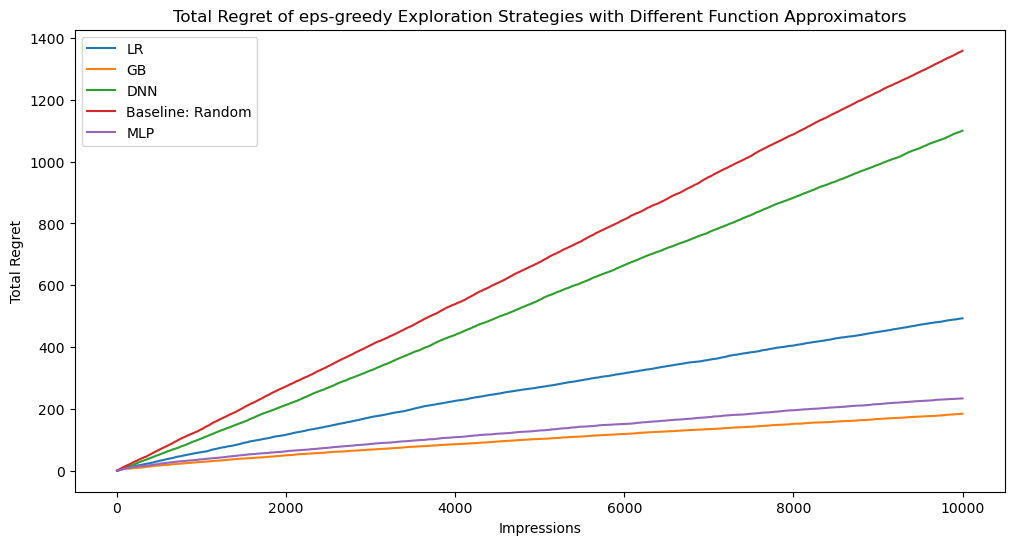

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
for e in eps:
    ax.plot(range(len(regret_vec_lr[e])), regret_vec_lr[e])
    ax.plot(range(len(regret_vec_gb[e])), regret_vec_gb[e])
    ax.plot(range(len(regret_vec_dnn[e])), regret_vec_dnn[e])
    ax.plot(range(len(regret_vec_dnn_random[e])), regret_vec_dnn_random[e])
    ax.plot(range(len(regret_vec_MLP[e])), regret_vec_MLP[e])
ax.set_ylabel('Total Regret')
ax.set_xlabel('Impressions')
ax.set_title('Total Regret of eps-greedy Exploration Strategies with Different Function Approximators')
ax.legend(['LR', 'GB', 'DNN','Baseline: Random', 'MLP'])
plt.show()